
# FOMC Policy Statements Topics:  Reading Between the Lines

*Alexander Ng,  Phil Tanofsky*

*May 20, 2022*

<img src="../raw/FOMC_Meeting.jpg" width="1200" />

**Source**  https://www.flickr.com/photos/federalreserve/26605969282/in/photostream/

## Summary

The Federal Open Market Committee (FOMC) sets the monetary policy of the United States by controlling interest rates
and, as the key decision making body of the Federal Reserve, by controlling the availability of the money and credit.  The FOMC
meets every 6-8 weeks to set and announce the policy.   It publishes a brief statement at the conclusion of each meeting.
The FOMC text is enormously influential to financial markets, businesses and governments.   We ask how textual analysis
can shed light on the FOMC statements through the recent critical period of the twenty-first century.

Using Latent Dirichlet Allocation, we construct a topic model of the FOMC statements from 2007-2022.  
Between January 2007-May 2022, we found 126 relevant FOMC policy statements. 

Our chief findings are that $N=5$ topics are sufficient to allow economic interpretation.
While the LDA model seems to detect topics based on the Federal Reserve quantitative easing policy more than the target interest rate.
Moreover, the high frequency words don't necessary reveal the topic.
Instead, we discovered that the link to Quantitative easing when we examine the dates when topic weights fluctuate in each FOMC statement.


This section begins by preprocessing the FOMC statement corpus.  Next, we train the LDA model and report the topics textually 
and graphically.   Next, we report the Time Variation of the Topics and their interpretation.   Lastly, we consider coherence as a topic evaluation measure for FOMC statements.   In our discussion, we consider potentially useful business application of LDA topic modeling as an automated form of Fed-watching.



## Pre-process and vectorize the documents

The statements were download and extracted in a previous step for consumption.  There are 126 statements for use.  We use `gensim`, `nltk` to preprocess the corpus.


In [2]:
%matplotlib inline

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import logging
logging.disable()

In [4]:
import io
import os.path
import math
#import requests
#from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import gensim
import gensim.corpora as corpora
from gensim import models
import matplotlib.pyplot as plt
#import spacy
from pprint import pprint
from wordcloud import WordCloud
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import seaborn as sns
import re as re
import smart_open

# Prepare corpus
derived_data_dir = "../derived"

fomc_statements_file = derived_data_dir + "/" + "FOMC_statements.csv"

df_fomc_statements_raw = pd.read_csv( fomc_statements_file )

docs = df_fomc_statements_raw.text

In [5]:
df_fomc_statements_raw.tail()

,statement_id,date,year,url,text,length,chairperson
121,122,2021-11-03,2021,https://www.federalreserve.gov/newsevents/pres...,The Federal Reserve is committed to using its ...,614,Powell
122,123,2021-12-15,2021,https://www.federalreserve.gov/newsevents/pres...,The Federal Reserve is committed to using its ...,521,Powell
123,124,2022-01-26,2022,https://www.federalreserve.gov/newsevents/pres...,Indicators of economic activity and employment...,430,Powell
124,125,2022-03-16,2022,https://www.federalreserve.gov/newsevents/pres...,Indicators of economic activity and employment...,348,Powell
125,126,2022-05-04,2022,https://www.federalreserve.gov/newsevents/pres...,Although overall economic activity edged down ...,366,Powell


In [6]:
ldocs = list(docs)


Following the approach suggested by [Radim Rehurek](https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#sphx-glr-auto-examples-tutorials-run-lda-py) in his LDA tutorial, our steps include:

* Tokenize (split the documents into tokens).
* Lemmatize the tokens.
* Compute bigrams.
* Compute a bag-of-words representation of the data.
* Convert the bag-of-words to Term Document - Inverse Document Frequency Weighting.

First we tokenize the text using a regular expression tokenizer from NLTK. We
remove numeric tokens and tokens that are only a single character, as they
don't tend to be useful, and the dataset contains a lot of them.

We also add FOMC specific stopwords as they don't appear to add value to the statements.
These include the words `chair`, `vice`, `voting`, `committee` and `FOMC`.
They also include the first and last names of all FOMC members from 2007-2022.   These were identified manually on the Federal Reserve website.


In [7]:
# Tokenize the documents.
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# common stop words in the English language
en_stopwords = stopwords.words('english')

# FOMC stop words
FOMC_stopwords = ['chair', 'vice', 'voting', 'committee', 'FOMC' ,
                 'john', 'williams', 'bowman', 'michelle', 'lael', 'brainard',
                  'james', 'bullard', 'esther', 'george', 'loretta', 'mester',
                  'christopher', 'waller'
                  'ben', 'bernanke', 'richard', 'clarida', 'stanley', 'fischer',
                  'susan', 'bies', 'elizabeth', 'duke', 'donald', 'kohn', 
                  'randall', 'kroszner', 'frederic', 'mishkin' ,
                  'jerome', 'powell', 'randal', 'quarles', 
                  'sarah', 'raskin', 'jeremy', 'stein' , 'daniel', 'tarullo',
                  'kevin', 'warsh', 'janet', 'yellen', 'tom', 'barkin',
                  'raphael', 'bostic' , 'mary', 'daly', 'william', 'dudley' ,
                  'charles', 'evans', 'fisher', 'timothy', 'geithner', 
                  'patrick', 'harker' , 'eric', 'rosengren', 'gary', 'stern',
                  'thomas', 'hoenig', 'robert', 'kaplan', 'neel', 'kashkari' ,
                  'narayana', 'kocherlakota', 'jeffrey', 'lacker', 
                  'dennis', 'lockhart' , 'cathy', 'minehan', 'michael', 'moskow',
                  'susan', 'pianalto', 'charles', 'plosser', 'william', 'poole'
                 ]

all_stopwords = set( en_stopwords + FOMC_stopwords )

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')

for idx in range(len(ldocs)):
    ldocs[idx] = ldocs[idx].lower()  # Convert to lowercase.
    ldocs[idx] = tokenizer.tokenize(ldocs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
ldocs = [[token for token in doc if not token.isnumeric()] for doc in ldocs]

# Remove words that are only one character.
ldocs = [[token for token in doc if len(token) > 1] for doc in ldocs]

We use the WordNet lemmatizer from NLTK. A lemmatizer is preferred over a
stemmer in this case because it produces more readable words. Output that is
easy to read is very desirable in topic modelling.




In [8]:
# Lemmatize the documents.
lemmatizer = WordNetLemmatizer()
lemma_docs = [[lemmatizer.lemmatize(token) for token in doc if token not in all_stopwords ] for doc in ldocs]

We find bigrams in the documents. Bigrams are sets of two adjacent words.
Using bigrams we can get phrases like "public_health" in our output
(spaces are replaced with underscores); without bigrams we would only get
"public" and "health".

Note that in the code below, we find bigrams and then add them to the
original data, because we would like to keep the words "public" and
"health" as well as the bigram "public_health".


In [9]:
# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 5 times or more).
bigram = Phrases(lemma_docs, min_count=10)
for idx in range(len(lemma_docs)):
    for token in bigram[lemma_docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            lemma_docs[idx].append(token)

We remove rare words and common words based on their *document frequency*.
Below we remove words that appear in less than 5 documents.
However, we keep words that appear in all documents like `inflation` because their
frequency and associated bigram phrases can be helpful.



In [10]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(lemma_docs)

# Filter out words that occur less than 5 documents, or more than 100% of the documents.
dictionary.filter_extremes(no_below=5, no_above=1.0)

Finally, we transform the documents to a vectorized form. We simply compute
the frequency of each word, including the bigrams.




In [11]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in lemma_docs]

Let's see how many tokens and documents we have to train on.

There are 754 tokens on 126 documents.



In [12]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(dictionary)

Number of unique tokens: 754
Number of documents: 126
Dictionary(754 unique tokens: ['action', 'action_ben', 'additional', 'ben', 'chairman']...)


We decided to use the Term-Document Inverse Document Frequency measure as it allows infrequent words
to have a great topic forming impact.

In [13]:
TFIDF = models.TfidfModel(corpus) # Fit TF-IDF model
trans_TFIDF = TFIDF[corpus] # Apply TF-IDF model

## Training

We are ready to train the LDA model. 

### Choosing the Number of Topics

How many topics should we use to train the model?  Our financial markets knowledge gives us some guidance although in the end there are no clear answers.  

*  First, the Federal Reserve has to a dual mandate:  managing inflation and promoting full employment consistent with a target level of inflation.   Thus, each statement is expected to address *inflation* and the *labor market*.

*  We know that a central bank is a lender of last resort.   It needs to rescue the national economy from financial crisis.
Thus, *financial crisis management* can be expected to be a relevant topic.  In particular, we can expect
    +   *quantitative easing*
    +   *extraordinary lending facility* (e.g. swap lines, TALF) to be potential topics.


*  The target Fed Funds rate is decided and announced at each FOMC meeting.  Thus, *rate setting* ought to be a topic.

*  Each statement also may provide forward guidance on the FOMC's trajectory of rate increases or crisis management measures.  This is consistent with the Federal Reserve's desire to improve transparency after the 2008 Financial crisis.

Because the statements are brief, we do not expect numerous topics to appear in the documents.  Parameter values in excess of 10 are likely to produce nonsensical results.   In addition, other academic research on the FOMC minutes suggest an optimal topic number of 8, see [Jegadeesh and Wu (2013)](https://doi.org/10.2139/ssrn.2939937).   We view FOMC minutes as an upper bound on the topic choice.  Minutes are lengthier versions of the meeting discussions associated with each FOMC statement. 

### Other Tuning Parameters

We choose other parameters based on the simplest version of the LDA model that `gensim` supports.

``passes`` controls how often we train the model on the entire corpus.
Another word for passes might be "epochs". ``iterations`` is somewhat
technical, but essentially it controls how often we repeat a particular loop
over each document. It is important to set the number of "passes" and
"iterations" high enough.

We set ``alpha = 'auto'`` and ``eta = 'auto'``. Essentially we are automatically learning two parameters in
the model that we usually would have to specify explicitly.


### Running the Model

Below, we run the model for $N=5$ topics which we decided is the optimal number of topics.   We use the extracted topic weights from the entire training corpus to see if each topic is used.   We discovered that LDA can created topics for which all documents in the training set have zero topic weight.

For $N=6$, we found the existence of a degenerate topic.
For $N=7$, we found a zero weight topic.

Thus, we choose $N=5$ because it is consistent with our a priori knowledge of FOMC statements and it avoids zero weight or degenerate topics.   A further tuning exercise below is done later using `U_Mass` coherence weight as a function of the number of topics.  This analysis does not recommend any useful optimal topic count.



In [14]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = 5
chunksize = 2000
passes = 30
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.
SEED = 12

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=trans_TFIDF,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    num_topics=num_topics,
    random_state = SEED ,
    passes=passes,
    eval_every=eval_every
)

### Extract Topic Ranking

The `gensim` framework is used to extract `U_Mass` topic coherence to rank the topic importance of each topic.

Within a model, the most coherent topic has the largest signed coherence.  
Between models of varying number of topics, the least signed coherence is preferred.

One unfortunate limitation of the `gensim` LDA model is that the native enumeration of `topic_id` does not provide the coherence score.
Meanwhile, the ranked order of topics provides the coherence scores but not `topic_id`.   So we have to join the coherence scores to `topic_id` indirectly by joining on related shared information.

The output of `top_topics` and `show_topics` includes the frequency of all words within each topic.
Thus, we join the two datasets on the common data element of:

* the probability of the leading word in each topic.

This is likely to be unique whereas the joining on the leading word will usually fail as topics often share the same leading words.

In [15]:
top_topics = model.top_topics(corpus = trans_TFIDF )

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

Average topic coherence: -1.4533.


In [16]:
topics = model.show_topics(num_words=1, formatted=False)
pprint(topics)

[(0, [('purchase', 0.008475071)]),
 (1, [('board', 0.009046477)]),
 (2, [('flow_credit', 0.008720476)]),
 (3, [('coming_quarter', 0.0069321087)]),
 (4, [('strong', 0.008922648)])]


In [17]:
rank = 0
topics_ranked = []
for word_props, coherence in top_topics:    
    rank += 1
    probs, words  = zip(*word_props)
    top_word = words[0]
    top_prob = probs[0]
    
    topics_ranked.append( [ rank, top_word, top_prob, coherence ] )
    
df_topics_ranked = pd.DataFrame( topics_ranked, columns = ["rank", "top_word", "top_prob", "coherence" ] )    

df_topics_ranked.head(10)     

,rank,top_word,top_prob,coherence
0,1,flow_credit,0.008720,-0.348400
1,2,purchase,0.008475,-0.402065
2,3,strong,0.008923,-1.190280
3,4,board,0.009046,-1.794918
4,5,coming_quarter,0.006932,-3.530968


In [18]:
topics_native = []

for topic_id, word_tuple in topics:
    
    topic_top_word = word_tuple[0][0]
    topic_top_prob = word_tuple[0][1]

    topics_native.append( [ topic_id, topic_top_word, topic_top_prob ] )

df_topics_native = pd.DataFrame( topics_native, columns = [ "topic_id", "topic_top_word", "topic_top_prob" ] )   
        
df_topics_native.head(10)


,topic_id,topic_top_word,topic_top_prob
0,0,purchase,0.008475
1,1,board,0.009046
2,2,flow_credit,0.008720
3,3,coming_quarter,0.006932
4,4,strong,0.008923


The resulting list of topics is shown below.

In [19]:
df_merge = df_topics_ranked.merge( df_topics_native, how = "left", 
                                  left_on = "top_prob", 
                                  right_on = "topic_top_prob" )[["top_word", "rank", "topic_id" , "top_prob", 
                                                                 "coherence" ] ]


df_topic_names = pd.DataFrame( data=[ ( 1 , 'QE4' ) , ( 2, 'QE3' ), (3 , 'QE-HALT' ), ( 4, 'QE1' ), (5, 'QE2' ) ], columns = ['rank', 'Topic'] )

df_merge = df_merge.merge( df_topic_names, how = 'left', on = 'rank' )

df_merge.head()

,top_word,rank,topic_id,top_prob,coherence,Topic
0,flow_credit,1,2,0.008720,-0.348400,QE4
1,purchase,2,0,0.008475,-0.402065,QE3
2,strong,3,4,0.008923,-1.190280,QE-HALT
3,board,4,1,0.009046,-1.794918,QE1
4,coming_quarter,5,3,0.006932,-3.530968,QE2


## Analysis of Topics

We analyze the LDA topics in several ways.

*  Examine highest frequency words.

*  Word Clouds

*  Time Series of Topic Weights within the training corpus

*  2 dimensional PCA analysis of intertopic distance.

In this case, we will conclude that time series analysis provides the most useful insights.  However, we consider
each method in turn and check for insights.

### Plotting Frequency Charts

We plot the frequencies of each topic's top 20 words in the below panel of barplots.
Above each barplot, we show in the chart title:

*   Topic ID
*   Topic Description
*   Topic Coherence
*   Topic Rank

For $K=5$ topics:

*  We observe that there are no degenerate topics.
*  We will defer interpretation of topics until we look at the time series of document topic weights.




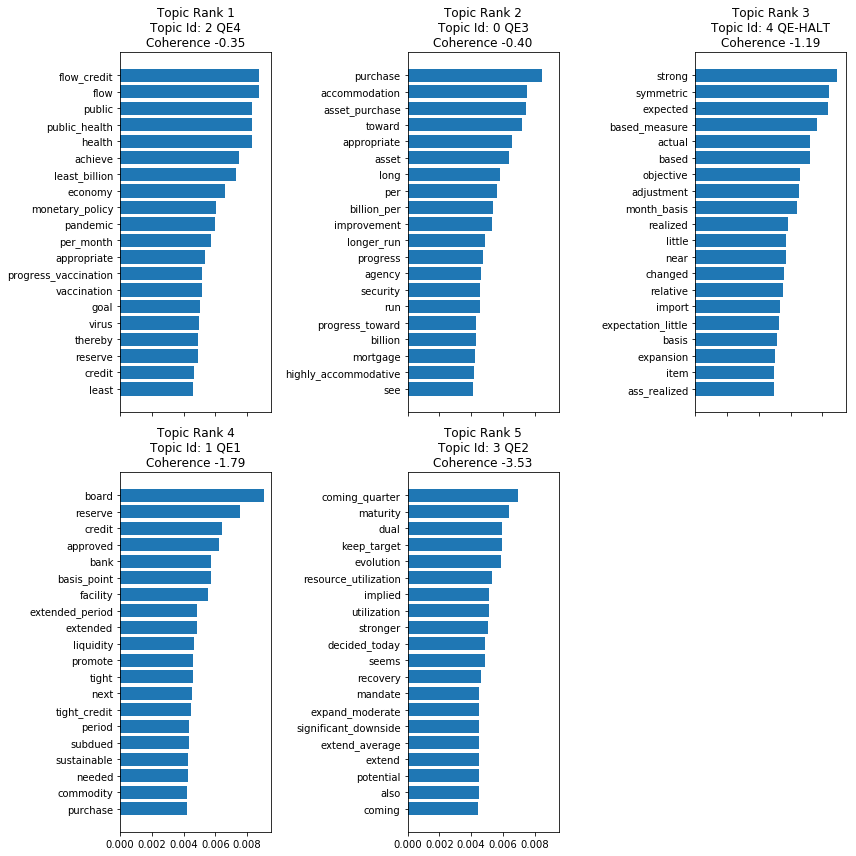

In [20]:
# Put all topic word subplots in a 2 row layout

rows = 2
cols = math.ceil( num_topics / 2 ) 

fig, axs = plt.subplots(nrows=rows, ncols=cols, sharex=True, figsize=(12, 12))
topic_rank = 0

for word_props, coherence in top_topics:
    
    row, col = divmod(topic_rank, cols )
    ax = axs[ row, col]
    probs, words  = zip(*word_props)
    
    ax.barh(words, probs)
    ax.invert_yaxis()
    topic_rank += 1
    
    topic_id = df_merge[ df_merge["rank"] == topic_rank ].iloc[0,2 ]
    topic_desc = df_merge[ df_merge["rank"] == topic_rank ].iloc[0,5 ]

    ax.set_title('Topic Rank {}\nTopic Id: {} {}\nCoherence {:.2f}'.format(topic_rank, topic_id , topic_desc, coherence))

# Delete empty subplots
for topic_rank in range( num_topics, rows * cols ):

    row, col = divmod(topic_rank, cols)
    ax = axs[ row, col]
    plt.delaxes( ax )
    topic_rank += 1
    
plt.tight_layout()
plt.show()

### Findings

What have we learned from the above frequency charts for each topic?

*   Topic ID 4 (`QE4`) is associated with the economic crisis induced by the Covid pandemic.  This is evident from the use of the high frequency words: `public`, `public_health` and `pandemic`, `virus`, `vaccination`.

*   Topic ID 0 (`QE3`) is associated with quantitative easing and asset purchases.  So we can confidently associated Topic 0 with Quantitative easing.  But since the FOMC has initiated multiple rounds of QE, we don't know which one the FOMC supports.   We will resolve this puzzle in the later section.

*   Topics 4, 1 and 3 are more ambiguous.   Studying the words does not tell you the key feature of the topic and they are all similar.   Moreover, the highest frequency words are non-specific.  `strong`, `symmetric`, `board`, `reserve`, `coming_quarter`, `maturity` are the top frequency words, but they don't less anything.



### Plotting Word Clouds

Word Clouds are generally less useful than frequency charts, but they allow overlooked words to be detected.
In this case, they are uninformative.

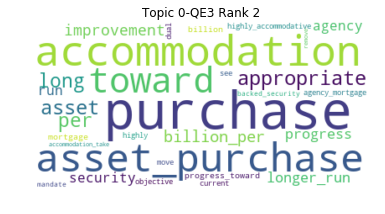

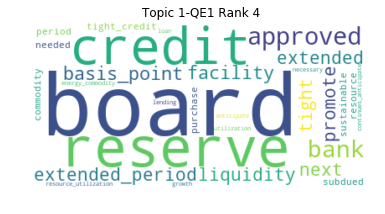

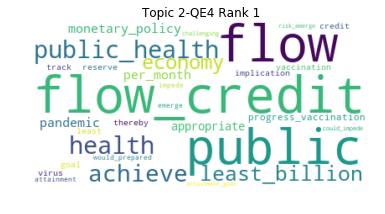

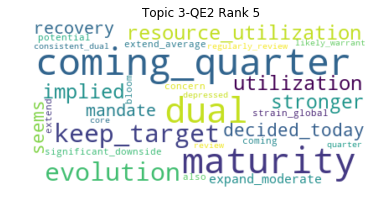

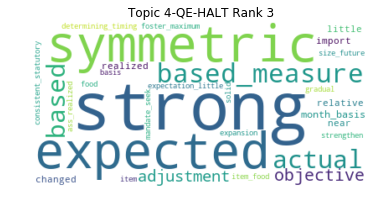

In [21]:
topic = 0 # Initialize counter
topic_rank = 0

while topic < num_topics:
    # Get topics and frequencies and store in a dictionary structure
    topic_words_freq = dict(model.show_topic(topic, topn=30)) # NB. the 'dict()' constructor builds dictionaries from sequences (lists) of key-value pairs - this is needed as input for the 'generate_from_frequencies' word cloud function
    
    # Generate Word Cloud for topic using frequencies
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(topic_words_freq) 
    
    topic_desc = df_merge[ df_merge["topic_id"] == topic ].iat[0, 5 ]
    topic_rank = df_merge[ df_merge['topic_id'] == topic ].iat[0, 1]
    
    plt.title("Topic {}-{} Rank {}".format(topic , topic_desc, topic_rank))    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    topic += 1



### Time Series

Finally, we consider the time evolution of each topic within the training corpus.

Each document is assigned a set of topics and weight.  The assigned topic identifiers follow the
internal numbering convention of the model.   After obtaining the set of all topic weights for all documents,
we will construct a dataframe $X$ of dimension $D \times T$ where $X(d,t)$ is the weight of document $d$ in topic $t$.
However, when $d$ has no association with topic $t$, $X(d,t) = 0$.



In [22]:

topic_history = []

for i in range(len(trans_TFIDF)):
    list_tuples = model[trans_TFIDF[i] ]
    for v in list_tuples:
        topic_id = v[0]
        topic_weight = v[1]
        topic_history.append( dict( zip( [ "statement_id", "topic_id", "topic_weight"] ,
                                         [ (i+1), topic_id, topic_weight ] ) ) )
        #print(i , " ", topic_id , " wt: ", topic_weight )
df_topic_history = pd.DataFrame( topic_history )

df_topic_history.head()

,statement_id,topic_id,topic_weight
0,1,3,0.970152
1,2,3,0.969345
2,3,3,0.970305
3,4,3,0.971399
4,5,3,0.973179


We transform the skinny table into a $D \times T$ dataframe using `pivot_table` functionality in pandas.

In [23]:
piv_topic_history = pd.pivot_table( df_topic_history, values = 'topic_weight', index = ['statement_id'], 
                                   columns = 'topic_id' ,
                                   fill_value = 0)
piv_topic_history.columns.name=None


Next, we add the FOMC statement date column as the dataframe index and drop the previous indices.

In [24]:
piv_topic_history["date"] = pd.to_datetime( df_fomc_statements_raw["date"].tolist() )
piv_topic_history.reset_index(inplace=True)
piv_topic_history = piv_topic_history.reset_index( drop = True )
piv_topic_history.set_index('date', inplace = True )

topic_weights_hist = piv_topic_history.loc[:, piv_topic_history.columns != 'statement_id'].copy(deep=True)

topic_weights_hist.head()

,0,1,2,3,4
date,,,,,
2007-01-31,0.0,0.0,0.0,0.970152,0.0
2007-03-21,0.0,0.0,0.0,0.969345,0.0
2007-05-09,0.0,0.0,0.0,0.970305,0.0
2007-06-28,0.0,0.0,0.0,0.971399,0.0
2007-08-07,0.0,0.0,0.0,0.973179,0.0


For ease of reading, we rename the columns from the topic i to the Quantitative easing topic descriptions.

In [25]:
topic_weights_hist.rename( columns = { 0 : 'QE3' , 1 : 'QE1' , 2 : 'QE4', 3 : 'QE2' , 4 : 'QE-HALT' }, inplace =True )

In [26]:
topic_weights_hist.head()

,QE3,QE1,QE4,QE2,QE-HALT
date,,,,,
2007-01-31,0.0,0.0,0.0,0.970152,0.0
2007-03-21,0.0,0.0,0.0,0.969345,0.0
2007-05-09,0.0,0.0,0.0,0.970305,0.0
2007-06-28,0.0,0.0,0.0,0.971399,0.0
2007-08-07,0.0,0.0,0.0,0.973179,0.0


### All Topics At Once

Before we examine each topic's history individually, we display them jointly.   A few observations are in order.

*   The topics display sharp boundary behavior.   Topics go in and out of use without significant transition.
This suggests that the LDA model is effective in detecting different subjects.

*   The topic transitions occur concurrently.  When one topic fades in importance, another topic takes over in importance.
This is consistent with the topic languages shiftly due to policy and the boiler plate language.

*   The sum of the topic weights do not exceed 100%.

*   Topic 0 (QE3) is clearly associated with quantitative easing because the highest frequency words:  `purchase`, `asset_purchase`, `accomodation`.

Text(0.5,1,'All Topic Weights 2007-2022')

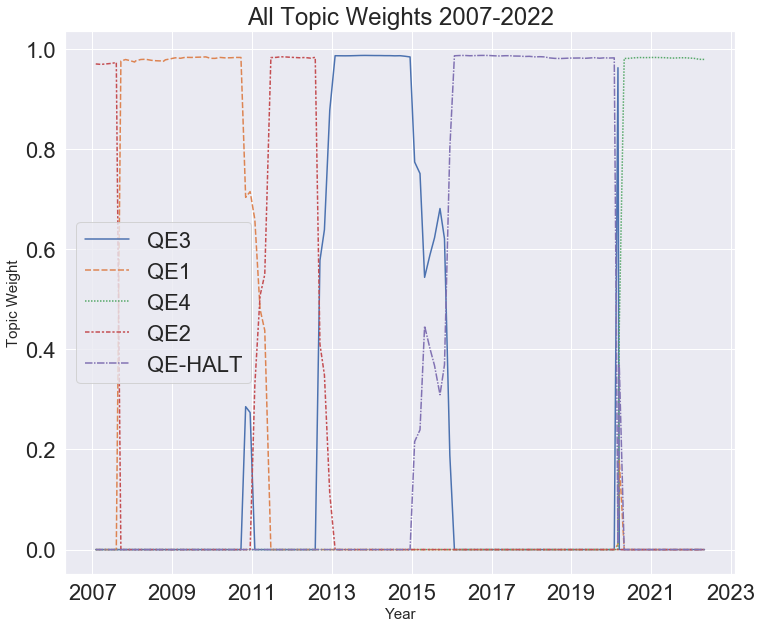

In [27]:
sns.set(rc = {'figure.figsize': (12,10) } )
sns.set(font_scale = 2 )
p = sns.lineplot( data=topic_weights_hist )
p.set_ylabel( "Topic Weight" , fontsize = 15 )
p.set_xlabel( "Year", fontsize = 15 )
plt.title("All Topic Weights 2007-2022")

In [28]:
sns.set(rc = {'figure.figsize': (6,6) } )
sns.set(font_scale = 1.3 )

#for i in range(num_topics):
#    if i in set(piv_topic_history.columns):    
#        sns.lineplot( data=piv_topic_history[[i]])
#        topic_rank = df_merge[ df_merge['topic_id'] == i ].iat[0, 1]
#        plt.title("Topic {}  Rank {}".format(i, topic_rank ) )
#        plt.show()

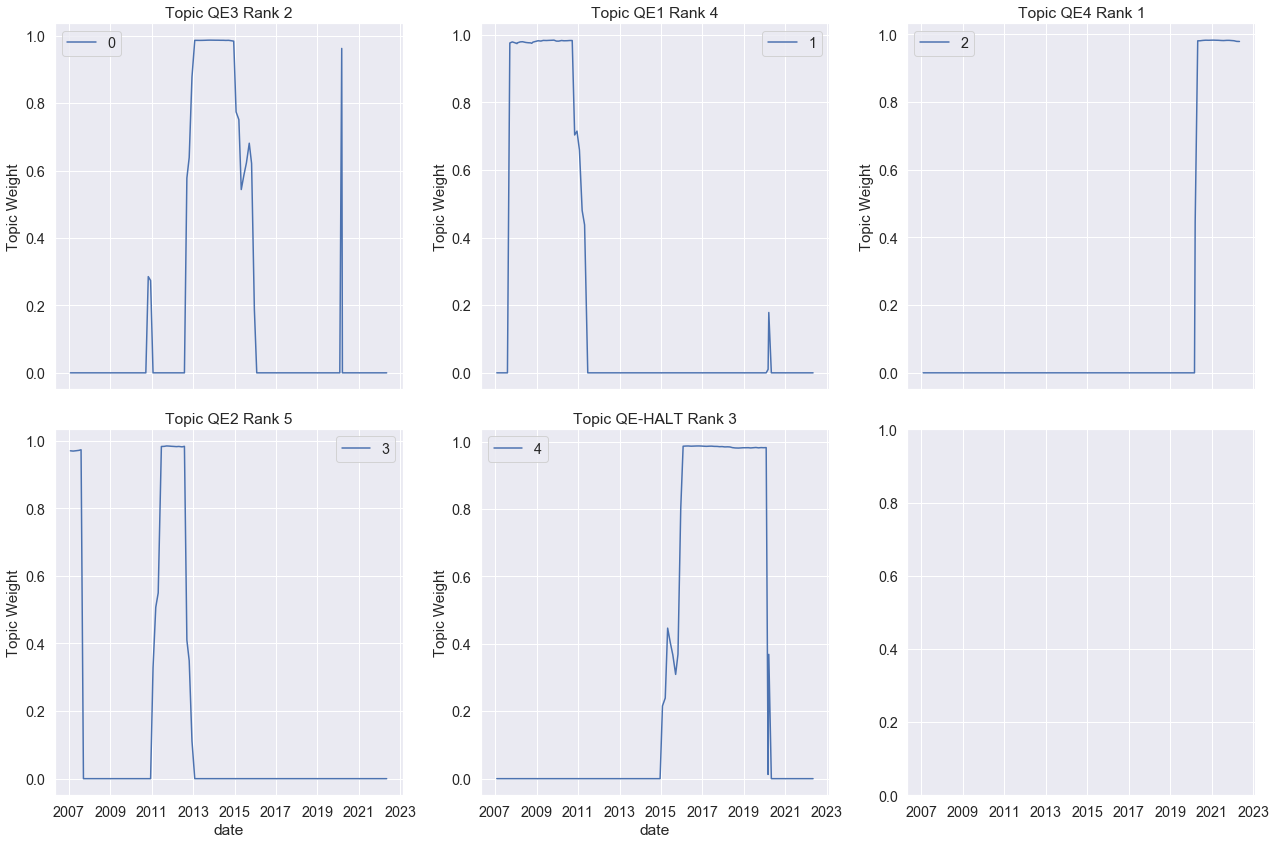

In [29]:
rows = 2
cols = math.ceil( num_topics / 2 ) 

fig, axs = plt.subplots(nrows=rows, ncols=cols, sharex=True, figsize=(18, 12))

#print(" rows: " , rows, " cols: " , cols )

for i in range(num_topics):
    if i in set(piv_topic_history.columns): 
        
        row, col = divmod(i, cols )

        ax = axs[ row, col]
        p = sns.lineplot( data=piv_topic_history[[i]], ax = ax)
        p.set_ylabel( "Topic Weight" , fontsize = 15 )
        topic_rank = df_merge[ df_merge['topic_id'] == i ].iat[0, 1]
        topic_desc = df_merge[ df_merge['topic_id'] == i ].iat[0, 5]
        ax.title.set_text("Topic {} Rank {}".format( topic_desc, topic_rank ) )
    
# Delete empty subplots
for i in range( num_topics ):
    if i not in set(piv_topic_history.columns ):
        print("not in i " , i )
        row, col = divmod(i, cols)
        ax = axs[ row, col]
        fig.delaxes( ax )

plt.tight_layout()
plt.show()

### Mapping Topics to Quantitative Easing Regimes

Quantitative easing (QE) is the central bank strategy to support financial markets by buying assets using the central bank's unlimited balance sheet.
Wikipedia observes:

>Quantitative easing is an unconventional form of monetary policy, which is usually used when inflation is very low or negative, and when standard monetary policy instruments have become [ineffective.](https://en.wikipedia.org/wiki/Quantitative_easing#United_States)

This approach was necessary in the 2007-2022 period because interest rates were so low.   When the Central bank hits the zero lower bound on interest rates, the bank's ability to encourage credit and investment is limited because interest rates cannot be lowered further.

Instead, the bank has embarked on four successive waves of asset purchases called QE1, QE2, QE3 and QE4.  See [Quantitative Easing](https://en.wikipedia.org/wiki/Quantitative_easing) for more details of the monetary policy and its implementation by major central banks.  We note that there is not universal agreement on the chronology and even naming of the waves of quantitative easing.   We follow the chronology and naming in [Wikipedia](https://en.wikipedia.org/wiki/Quantitative_easing#United_States) but note that [The Balance](https://www.thebalance.com/what-is-quantitative-easing-definition-and-explanation-3305881) give different dates and even consider QE4 to be an extension of QE3.


The following amazing chart below from the visualcapitalist.com shows the phases and amounts of purchases with each wave of quantitative easing.
(https://www.visualcapitalist.com/the-feds-balance-sheet-the-other-exponential-curve/)

<img src="../raw/fed-balance-sheet-exponential-covid-19.jpg" width="1200" />


The table below summarizes the QE program dates when the Federal Reserve started and ended buying of assets and compares them to the dates when each topic has significant non-zero weight (typically more than 10%).


In [30]:
list_qe = [ ( 1 ,  'flow_credit, flow, public, public_health' , 'QE4' , 'March 2020 - May 2022' , 'March 2020 - March 2022' ) ,
            ( 2 ,  'purchase, accomodation, asset_purchase, toward' , 'QE3' , 'Sep 2012-Oct 2015, Mar 2020' , 'Sep 2012-Oct 2014' ) ,
            ( 3 ,  'strong, symmetric, expected, based_measure' , 'QE-HALT' , 'Jan 2015-Jan 2020' , 'Nov 2015-Feb 2020' ) ,
            ( 4 ,  'board, reserve, credit, approved' , 'QE1' , 'Sep 2007-Apr 2011' , 'Nov 2008-Sep 2010' ) ,
            ( 5 ,  'coming_quarter, maturity, dual, keep_target' , 'QE2' , 'Jan 2011-Sep 2012' , 'Nov 2010-June 2011' ) 
          
          ]

df_qe = pd.DataFrame( data = list_qe , columns = ['Rank', 'Key Words', 'Topic' , 'LDA-Dates' , 'Actual-Dates' ] )
df_qe.reset_index( drop= True )
heading_properties = [('font-size', '18px')]

cell_properties = [('font-size', '16px')]

dfstyle = [dict(selector="th", props=heading_properties), dict(selector="td", props=cell_properties)]

df_qe.style.set_table_styles(dfstyle)


,Rank,Key Words,Topic,LDA-Dates,Actual-Dates
0,1,"flow_credit, flow, public, public_health",QE4,March 2020 - May 2022,March 2020 - March 2022
1,2,"purchase, accomodation, asset_purchase, toward",QE3,"Sep 2012-Oct 2015, Mar 2020",Sep 2012-Oct 2014
2,3,"strong, symmetric, expected, based_measure",QE-HALT,Jan 2015-Jan 2020,Nov 2015-Feb 2020
3,4,"board, reserve, credit, approved",QE1,Sep 2007-Apr 2011,Nov 2008-Sep 2010
4,5,"coming_quarter, maturity, dual, keep_target",QE2,Jan 2011-Sep 2012,Nov 2010-June 2011


The date alignment of the start of QE4 and QE3 are very close to the actual QE policy changes.   The end of the QE is sometimes left clearly identified by the LDA algorithm.   The halt of QE1 is not well identified.  But the entire 2007-2008 period was an extended series of increasingly severe financial market disruptions.  The identification of QE2 is quite close (within 3 months).

While the high frequency words of each topic does not appear to suggest a change in QE policy, the time evolution of topic weights gives us more precise, hidden patterns.

### Interactive Visualization Of Topics

We also evaluate the LDA model interactively using the `pyLDAvis` package below.

The `pyLDAvis` visualization produces an intertopic distance map using MDS (multidimensionsal scaling) to produce
a principal components plot of PCA dimensions 1 and 2 (labelled `PC1`, `PC2`).    

The main conclusion from this plot is that $K=5$ topic model has well-separated topics.  Strong topic separation implies the model is able to distinguish topics and gives us greater confidence in the model fit.  Topics are well separated when their associated circles don't overlap in the intertopic distance map.
In this case, the only overlaps occur between  `QE1` (the circle labeled 2) and `QE2` (the circle labeled 4).

We do not see any business insights about the FOMC statements from the PCA visualization.  Moreover, the term bar chart is nearly equivalent in content to the earlier frequency bar charts.  


In [31]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare( model, trans_TFIDF , dictionary, sort_topics = False)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.004614  0.010697       1        1  23.092386
1      0.084270 -0.038917       2        1  20.731651
2     -0.004024  0.099616       3        1  13.837058
3      0.038960 -0.032001       4        1  12.748553
4     -0.123821 -0.039394       5        1  29.590352, topic_info=               Term      Freq     Total Category  logprob  loglift
114           board  3.000000  3.000000  Default  30.0000  30.0000
714     flow_credit  2.000000  2.000000  Default  29.0000  29.0000
713            flow  2.000000  2.000000  Default  28.0000  28.0000
717          public  2.000000  2.000000  Default  27.0000  27.0000
718   public_health  2.000000  2.000000  Default  26.0000  26.0000
..              ...       ...       ...      ...      ...      ...
462       objective  2.619771  4.332734   Topic5  -5.0174   0.7146
267      strengthen  1.940622  2.746975   Topic5  -5.3175   0.8702
112           basis  2.027768  3.327236   Topic5  -5.2736   0.7225
327         gradual  1.953557  2.998648   Topic5  -5.3109   0.7892
487  foster_maximum  1.843610  2.688464   Topic5  -5.3688   0.8405

[250 rows x 6 columns], token_table=      Topic      Freq                   Term
term                                        
468       1  0.670613          accommodation
569       1  0.616684     accommodation_take
684       5  0.961312  accommodative_thereby
711       3  0.527189                achieve
664       5  0.897446                 actual
...     ...       ...                    ...
632       1  0.709252            view_normal
694       5  0.948916          view_realized
734       3  0.695929                  virus
374       2  0.653644                 wealth
749       3  0.749618         would_prepared

[267 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

From the `pyLDAvis` visualization, we conclude that the topics are well separated.   A lack of overlapping circles, each of which represents a topic, tells us that the model is doing a good job in identifying distinct topics.  In this case, the only overlaps occur between  `QE1` (the circle labeled 2) and `QE2` (the circle labeled 4).

We do not see any business insights about the FOMC statements from the PCA visualization.  Moreover, the term bar chart is nearly equivalent in content to the earlier frequency bar charts.  

## Optimization Based on Coherence

Given our discovery that the LDA topics align with the Quantitative Easing regimes, it is not surprisingly that
topic searches higher than $K=5$ topics appear unstable below.   LDA is seeking to match topics but they become more granular.
In some cases, model coherence minimizes the U_Mass coherence but generally it seems a tenuous decision rule to calibrate the number of topics.

In [32]:
mod_results = []

for nt in [ 2, 3, 4, 5, 6, 7, 8, 9]:
     # Set training parameters.
     chunksize = 2000
     passes = 30
     iterations = 400
     eval_every = None  # Don't evaluate model perplexity, takes too much time.
     SEED = 12

     # Make an index to word dictionary.
     temp = dictionary[0]  # This is only to "load" the dictionary.
     
     ldamod = LdaModel(
          corpus=trans_TFIDF,
          id2word=id2word,
          chunksize=chunksize,
          alpha='auto',
          eta='auto',
          num_topics=nt,
          random_state = SEED ,
          passes=passes,
          eval_every=eval_every
     )
     
     cur_top_topics = ldamod.top_topics(corpus = trans_TFIDF )
     # Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
     avg_topic_coherence = sum([t[1] for t in cur_top_topics]) / nt
     #print('Average topic coherence: %.4f.' % avg_topic_coherence, "length: ", len(top_topics ) )
     
     mod_results.append( ( nt,  avg_topic_coherence ) )



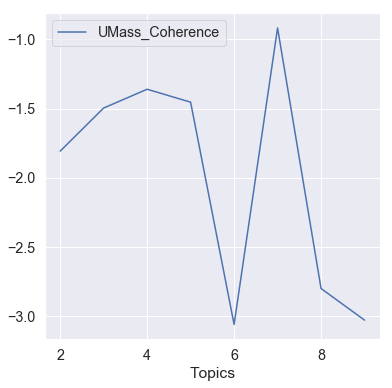

In [33]:
df_mod_results = pd.DataFrame( mod_results , columns = ['Topics', 'UMass_Coherence'] )
df_mod_results.plot(x="Topics", y = "UMass_Coherence")

## Discussion

The text patterns of the FOMC statements appear to change when new programs of Quantitative easing are introduced.
This is consistent with the central bankers wishing to signal a change of monetary policy through a change in text style.
The views of market participants will be moved by single adjective changes between consecutive statements.
Consequently, when LDA -- a relatively blunt instrument -- is able to detect topic changes, it foreshadows real policy changes by the FOMC.

It is easy to understand why the topic change is detected accurately by LDA when a new wave of QE starts.
However, it is harder to understand why the topic change detection is less accurate when QE ends.

One possible explanation for this assymmetry is that the curtailment of asset purchases depends on data conditions.
Another reason is that new QE requires more upfront explanation, while terminating QE simply involves slowing asset purchases
and not reinvesting maturing proceeds.

It is unclear if LDA topic weight changes can replace more sophisticated human expert in this area.  Besides the FOMC statements, a human analyst
would examine FOMC minutes, transcripts, Beige Book, Blue Book , speeches and market commentary from other experts.  These works would shed
insight beyond what an LDA model can provide.  However, LDA provides a concrete measurement of what an analyst may struggle to express in words, his subjective opinion of future FOMC decision making.


## Technical Appendix

The data table for the QE program topics in the LDA model is shown below.

In [34]:
with pd.option_context('display.max_rows' , 200 ):
    print(topic_weights_hist )

                 QE3       QE1       QE4       QE2   QE-HALT
date                                                        
2007-01-31  0.000000  0.000000  0.000000  0.970152  0.000000
2007-03-21  0.000000  0.000000  0.000000  0.969345  0.000000
2007-05-09  0.000000  0.000000  0.000000  0.970305  0.000000
2007-06-28  0.000000  0.000000  0.000000  0.971399  0.000000
2007-08-07  0.000000  0.000000  0.000000  0.973179  0.000000
2007-09-18  0.000000  0.975816  0.000000  0.000000  0.000000
2007-10-31  0.000000  0.978990  0.000000  0.000000  0.000000
2007-12-11  0.000000  0.976799  0.000000  0.000000  0.000000
2008-01-22  0.000000  0.974007  0.000000  0.000000  0.000000
2008-01-30  0.000000  0.976185  0.000000  0.000000  0.000000
2008-03-18  0.000000  0.979066  0.000000  0.000000  0.000000
2008-04-30  0.000000  0.979544  0.000000  0.000000  0.000000
2008-06-25  0.000000  0.977396  0.000000  0.000000  0.000000
2008-08-05  0.000000  0.976586  0.000000  0.000000  0.000000
2008-09-16  0.000000  0.

/Volumes/GDRIVE_SSD/Applications/anaconda3/anaconda3/envs/sps620env/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Volumes/GDRIVE_SSD/Applications/anaconda3/anaconda3/envs/sps620env/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Volumes/GDRIVE_SSD/Applications/anaconda3/anaconda3/envs/sps620env/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Volumes/GDRIVE_SSD/Applications/anaconda3/anaconda3/envs/sps620env/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of 